In [8]:
import random
from gymnasium import Env, spaces
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [9]:
class WarehouseRobotEnv(Env):
    def __init__(self, deterministic=True):
        super().__init__()
        
        self.grid_size = (6, 6)
        self.agent_pos = [0, 0]  
        self.package_pos = [0, 1]  # Initial package position
        self.dropoff_pos = [0, 4]  # Fixed dropoff point (yellow block)
        self.obstacles = [[1, 1], [1, 2], [2, 1]]  # Shelves
        self.has_package = False
        self.dropped_off = False
        self.trail = []  # To store agent's path
        self.deterministic = deterministic  # Flag to control stochastic or deterministic behavior
        
        # Define action space: Up, Down, Left, Right, Pickup, Dropoff
        self.action_space = spaces.Discrete(6)
        
        # Observation space: (agent_pos, has_package)
        self.observation_space = spaces.Tuple((
            spaces.MultiDiscrete([6, 6]),
            spaces.Discrete(2)
        ))

        # Track cumulative reward
        self.cumulative_reward = 0

    def reset(self):
        self.agent_pos = [0, 0]
        self.package_pos = [0, 1]  # Reset package position
        self.has_package = False
        self.dropped_off = False
        self.trail = []  # Reset trail
        self.cumulative_reward = 0  # Reset cumulative reward
        return self._get_obs(), {}

    def step(self, action):
        reward = -1  # Default step penalty
        terminated = False

        # Store the current position in the trail before moving
        self.trail.append(tuple(self.agent_pos))

        # Movement actions (0-3)
        if action < 4:
            new_pos = self._move_agent(action)
            if not self._is_valid(new_pos):
                reward = -15  # Penalty for invalid move (out of grid)
            elif not self._is_collision(new_pos):
                self.agent_pos = new_pos
            else:
                reward = -20  # Collision penalty

        # Pickup (4)
        elif action == 4:
            if self.agent_pos == self.package_pos and not self.has_package:
                self.has_package = True
                reward = 25
            else:
                reward = -5  # Penalty for invalid pickup
        
        # Dropoff (5)
        elif action == 5:
            if self.has_package:
                self.package_pos = self.agent_pos.copy()  # Set new package position
                self.has_package = False  # Drop the package
                reward = -10  # Reward for a valid drop
                
                # If dropped at the fixed dropoff point, end episode
                if self.agent_pos == self.dropoff_pos:
                    self.dropped_off = True
                    terminated = True
                    reward = 100
            else:
                reward = -5  # Penalty for invalid dropoff

        # Update cumulative reward
        self.cumulative_reward += reward

        # Capture next state
        next_state = self._get_obs()
        
        # Render environment state
        self.render()

        return next_state, reward, terminated, False, {}

    def _get_obs(self):
        return (tuple(self.agent_pos), int(self.has_package))

    def _move_agent(self, action):
        if self.deterministic or random.random() < 0.9:
            # 90% chance: execute the intended move
            moves = {
                0: [1, 0],  # Up
                1: [-1, 0],   # Down
                2: [0, -1],  # Left
                3: [0, 1]    # Right
            }
            delta = moves[action]
            new_pos = [
                self.agent_pos[0] + delta[0],
                self.agent_pos[1] + delta[1]
            ]
        else:
            # 10% chance: stay in the current position
            new_pos = self.agent_pos.copy()
        
        return new_pos

    def _is_collision(self, pos):
        return pos in self.obstacles
    
    def _is_valid(self, pos):
        x, y = pos
        return 0 <= x < 6 and 0 <= y < 6 and pos not in self.obstacles

    def render(self):
        fig, ax = plt.subplots()
        ax.set_xlim(0, 6)
        ax.set_ylim(0, 6)

        # Draw grid
        for x in range(7):
            ax.axvline(x, color='k')
        for y in range(7):
            ax.axhline(y, color='k')

        # Draw obstacles
        for obs in self.obstacles:
            ax.add_patch(Rectangle(
                (obs[1], obs[0]), 1, 1, facecolor='black'
            ))

        # Draw package if not picked up
        if self.package_pos and not self.has_package:
            ax.add_patch(Rectangle((self.package_pos[1], self.package_pos[0]), 1, 1, facecolor='green'))
        
        # Draw dropoff point
        ax.add_patch(Rectangle((self.dropoff_pos[1], self.dropoff_pos[0]), 1, 1, facecolor='yellow'))

        # Draw agent
        ax.add_patch(Rectangle(
            (self.agent_pos[1], self.agent_pos[0]), 1, 1,
            facecolor='blue' if self.has_package else 'red'
        ))

        plt.show()

        # Adjusting the grid layout to match visualization
        grid = [[". " for _ in range(6)] for _ in range(6)]
        
        # Place obstacles
        for obs in self.obstacles:
            grid[5 - obs[0]][obs[1]] = "X "  # Obstacle
        
        # Place package if not picked up
        if self.package_pos and not self.has_package:
            grid[5 - self.package_pos[0]][self.package_pos[1]] = "P "
        
        # Place dropoff point
        grid[5 - self.dropoff_pos[0]][self.dropoff_pos[1]] = "D "
        
        # Place agent
        if self.has_package:
            grid[5 - self.agent_pos[0]][self.agent_pos[1]] = "A*"
        else:
            grid[5 - self.agent_pos[0]][self.agent_pos[1]] = "A "
        
        for row in grid:
            print("".join(row))
        print("\n")

In [10]:
# Simulation function
def run_simulation(deterministic=True, num_steps=100):
    env = WarehouseRobotEnv(deterministic=deterministic)
    obs, _ = env.reset()
    
    print("Initial Grid:")
    env.render()
    
    for step in range(num_steps):
        action = env.action_space.sample()  # Random action
        obs, reward, done, _, _ = env.step(action)
        action_map = {0: 'Up', 1: 'Down', 2: 'Left', 3: 'Right', 4: 'Pickup', 5: 'Dropoff'}
        
        print(f"Step: {step + 1}")
        print(f"Action: {action} ({action_map[action]})")
        print(f"Reward: {reward}")
        print(f"Cumulative Reward: {env.cumulative_reward}")
        print(f"Agent Position: {obs[0]}")
        print(f"Has Picked Up: {bool(obs[1])}\n")
        
        if done:
            print("Episode finished!")
            break

# DETERMINISTIC

Deterministic Simulation:
Initial Grid:


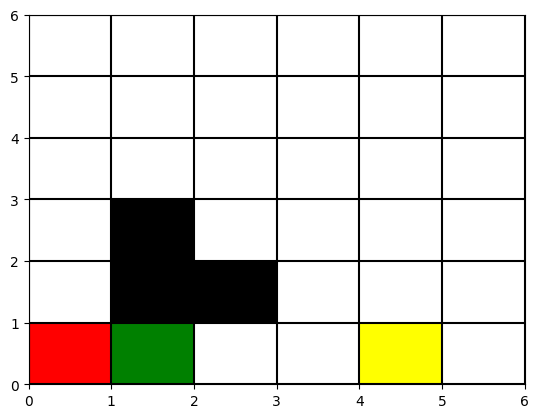

. . . . . . 
. . . . . . 
. . . . . . 
. X . . . . 
. X X . . . 
A P . . D . 




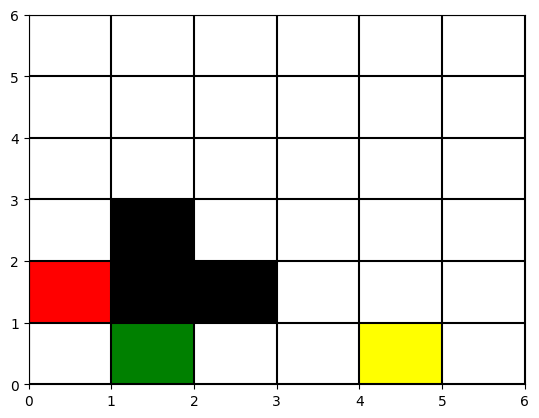

. . . . . . 
. . . . . . 
. . . . . . 
. X . . . . 
A X X . . . 
. P . . D . 


Step: 1
Action: 0
Reward: -1
Agent Position: (1, 0)
Has Picked Up: False



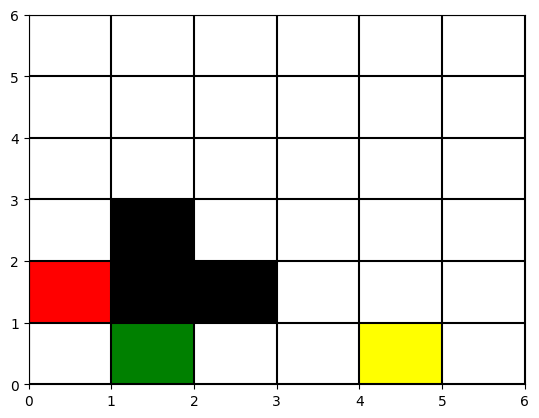

. . . . . . 
. . . . . . 
. . . . . . 
. X . . . . 
A X X . . . 
. P . . D . 


Step: 2
Action: 5
Reward: -10
Agent Position: (1, 0)
Has Picked Up: False



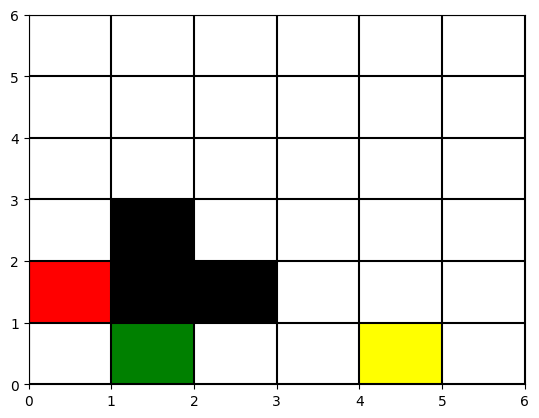

. . . . . . 
. . . . . . 
. . . . . . 
. X . . . . 
A X X . . . 
. P . . D . 


Step: 3
Action: 3
Reward: -15
Agent Position: (1, 0)
Has Picked Up: False



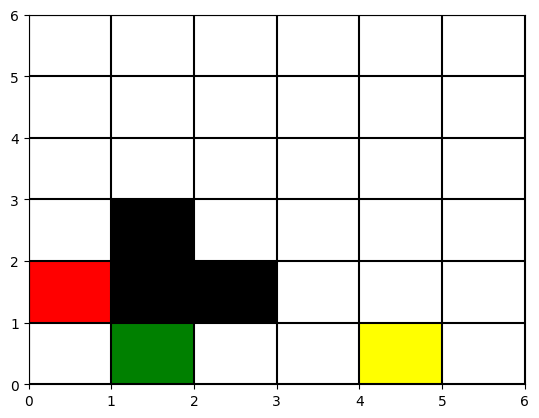

. . . . . . 
. . . . . . 
. . . . . . 
. X . . . . 
A X X . . . 
. P . . D . 


Step: 4
Action: 4
Reward: -10
Agent Position: (1, 0)
Has Picked Up: False



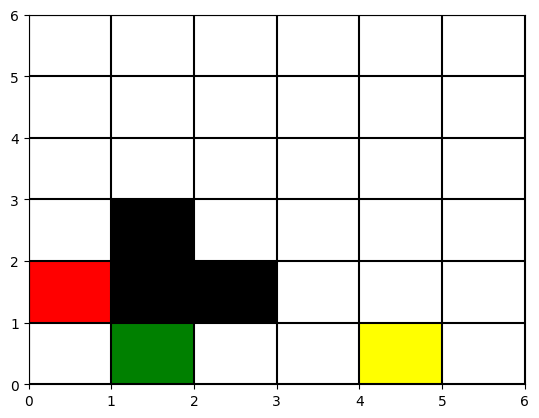

. . . . . . 
. . . . . . 
. . . . . . 
. X . . . . 
A X X . . . 
. P . . D . 


Step: 5
Action: 4
Reward: -10
Agent Position: (1, 0)
Has Picked Up: False



In [11]:
print("Deterministic Simulation:")
# Run a simulation
run_simulation(deterministic=True, num_steps=5)



# STOCHASTIC


Stochastic Simulation:
Initial Grid:


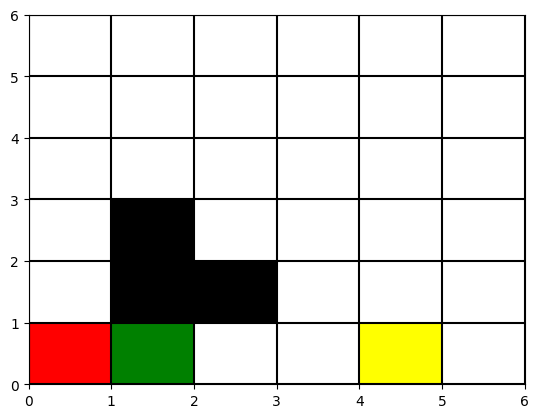

. . . . . . 
. . . . . . 
. . . . . . 
. X . . . . 
. X X . . . 
A P . . D . 




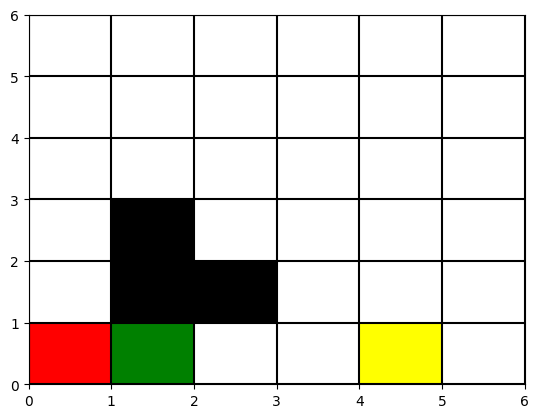

. . . . . . 
. . . . . . 
. . . . . . 
. X . . . . 
. X X . . . 
A P . . D . 


Step: 1
Action: 1
Reward: -15
Agent Position: (0, 0)
Has Picked Up: False



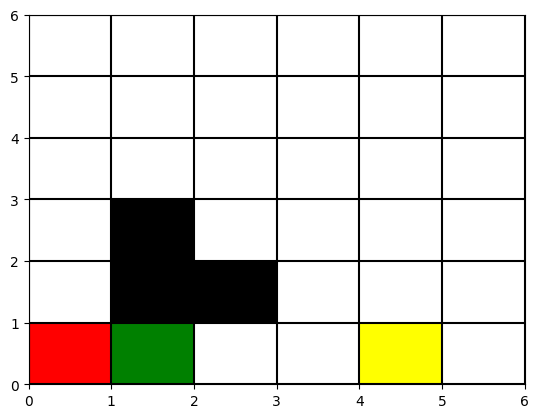

. . . . . . 
. . . . . . 
. . . . . . 
. X . . . . 
. X X . . . 
A P . . D . 


Step: 2
Action: 2
Reward: -15
Agent Position: (0, 0)
Has Picked Up: False



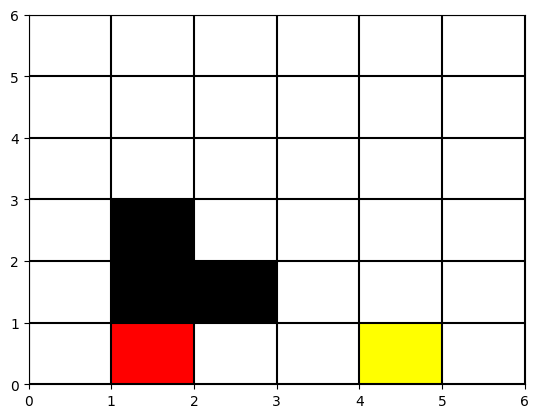

. . . . . . 
. . . . . . 
. . . . . . 
. X . . . . 
. X X . . . 
. A . . D . 


Step: 3
Action: 3
Reward: -1
Agent Position: (0, 1)
Has Picked Up: False



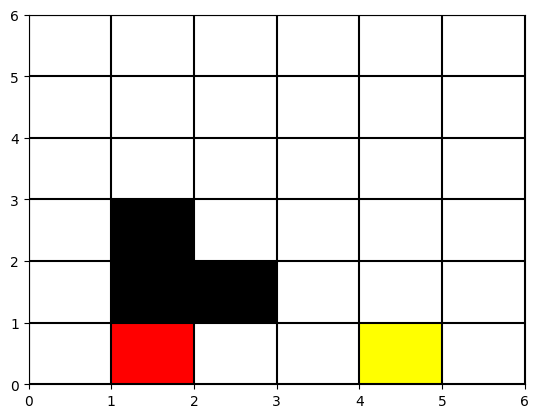

. . . . . . 
. . . . . . 
. . . . . . 
. X . . . . 
. X X . . . 
. A . . D . 


Step: 4
Action: 1
Reward: -15
Agent Position: (0, 1)
Has Picked Up: False



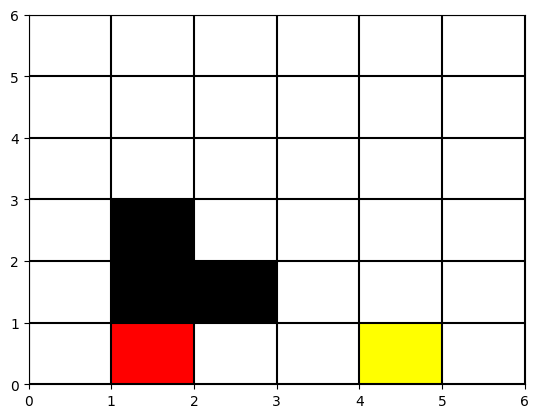

. . . . . . 
. . . . . . 
. . . . . . 
. X . . . . 
. X X . . . 
. A . . D . 


Step: 5
Action: 5
Reward: -10
Agent Position: (0, 1)
Has Picked Up: False



In [12]:
# Run stochastic simulation
print("\nStochastic Simulation:")
run_simulation(deterministic=False, num_steps=5)